# Large Vision & Language Decoder Models


In [ ]:
#!pip install transformers==4.47.0
#!pip install -U bitsandbytes

import requests
from PIL import Image
import torch 
from transformers import (
  LlavaForConditionalGeneration,
  AutoTokenizer,
  AutoProcessor,
  StopStringCriteria,
  BitsAndBytesConfig
)

def cuda_info():
    print()
    print("cuda.is_available: \t", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("cuda.device_count: \t", torch.cuda.device_count())
        print("cuda.current_device: \t", torch.cuda.current_device())
        print("cuda.device: \t\t", torch.cuda.device(torch.cuda.current_device()))
        print()
        print("cuda.get_device_name: \t", torch.cuda.get_device_name(torch.cuda.current_device()))
        print("total memory: \t\t", torch.cuda.get_device_properties(0).total_memory)
        print("reserved memory:\t", torch.cuda.memory_reserved(0))
        print("allocated memory:\t", torch.cuda.memory_allocated(0))


    device = "cuda:" + str(torch.cuda.current_device()) if torch.cuda.is_available() else "cpu"
    print()
    print("device name: \t\t", device)
    return device

device = cuda_info()



cuda.is_available: 	 True
cuda.device_count: 	 1
cuda.current_device: 	 0
cuda.device: 		 <torch.cuda.device object at 0x7fd23c9398e0>

cuda.get_device_name: 	 NVIDIA GeForce RTX 3050 Ti Laptop GPU
total memory: 		 4294508544
reserved memory:	 0
allocated memory:	 0

device name: 		 cuda:0


In [ ]:
checkpoint = "Intel/llava-gemma-2b"

# Load model
model = LlavaForConditionalGeneration.from_pretrained(checkpoint).to(device)

# If your GPU has limited memory, you can use quantization_config to load the model in 8-bit:
#quantization_config = BitsAndBytesConfig(load_in_8bit=True, llm_int8_threshold=200.0)
#model = LlavaForConditionalGeneration.from_pretrained(checkpoint, 
#                                                      quantization_config=quantization_config,
#                                                      do_sample=False)

processor = AutoProcessor.from_pretrained(checkpoint)

cuda_info()

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]


cuda.is_available: 	 True
cuda.device_count: 	 1
cuda.current_device: 	 0
cuda.device: 		 <torch.cuda.device object at 0x7fd1f0bbf2f0>

cuda.get_device_name: 	 NVIDIA GeForce RTX 3050 Ti Laptop GPU
total memory: 		 4294508544
reserved memory:	 3365928960
allocated memory:	 3347423232

device name: 		 cuda:0


'cuda:0'

# Load an example image

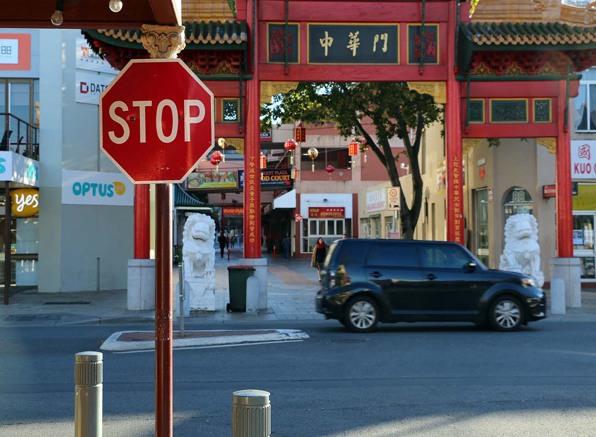

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.


user

What's the content of the image?
model
The image features a red stop sign on a city street, with a red and white sign on a pole nearby. There is a red and white


In [ ]:
url = "https://www.ilankelman.org/stopsigns/australia.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')  
display(image.resize((596, 437)))


# Prompted image captioning

In [5]:
prompt = "<image>The car is"

inputs = processor(images=image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
print(generated_text)


<bos><image>The car is driving down the street.<end_of_turn>
Lion statue on the sidewalk.<end_of_turn>
Lion statue on the sidewalk


# Chat Template

In [7]:
# Use gemma chat template
prompt = processor.tokenizer.apply_chat_template(
    [{'role': 'user', 'content': "<image>\nWhat's the content of the image?"}],
    tokenize=False,
    add_generation_prompt=True
)
inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
generate_ids = model.generate(**inputs, max_length=50)
output = processor.batch_decode(generate_ids, skip_special_tokens=False, clean_up_tokenization_spaces=False)[0].strip()
print(output)


<bos><bos><start_of_turn>user
<image>
What's the content of the image?<end_of_turn>
<start_of_turn>model
The image features a red stop sign on a city street, with a red and white sign on a pole nearby. There is a red and white


In [8]:
# Use gemma chat template
prompt = processor.tokenizer.apply_chat_template(
    [{'role': 'user', 'content': "<image>\nWhat's the content of the image?"}],
    tokenize=False,
    add_generation_prompt=True
)
inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
generate_ids = model.generate(**inputs, stopping_criteria = [StopStringCriteria(tokenizer = processor.tokenizer, stop_strings=["<end_of_turn>"])], max_length=80)
output = processor.batch_decode(generate_ids, skip_special_tokens=False, clean_up_tokenization_spaces=False)[0].strip()
print(output)


<bos><bos><start_of_turn>user
<image>
What's the content of the image?<end_of_turn>
<start_of_turn>model
The image features a red stop sign on a city street, with a red and white sign on a pole nearby. There is a red and white stop sign on the sidewalk, and a red and white stop sign on a pole. A car is driving down the street, and a person is crossing
